In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [16]:
########## All constants ########
    # Canny constants #
low_threshold       = 50
high_threshold      = 150
rho                 = 1                            
theta               = np.pi/180                   
threshold           = 40                      
min_line_length     = 15                
max_line_gap        = 1   
    # Region of interest constants #
xfd                 = 40
yfd                 = 325
#################################

In [17]:
def slope(line):
    try:
        [x1,y1,x2,y2] = line
        slope = (y2-y1)/(x2-x1)
    except ZeroDivisionError:
        slope = 0      
    return slope
def intersect(vx, vy, cx, cy, fy):
    m = (vy/vx)
    b = cy - m * cx
    return [int((fy-b)/m),int(fy)]

In [18]:
def gaussian_blur(img ,kernel_size = 5):
    return cv2.GaussianBlur(img,(kernel_size, kernel_size),0)

In [19]:
def canny(img,low_thresh,high_thresh):
    return cv2.Canny(img, low_thresh, high_thresh)

In [20]:
def region_of_interest(img,vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
       channel_numb = img.shape[2]
       ignore_mask_color = (255,)*channel_numb
    else:
       ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    return cv2.bitwise_and(img, mask)

In [21]:
def hough(img,rho,theta,threshold,min_line_length,max_line_gap):
    lines      = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    line_image = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_image, lines)
    return line_image

In [22]:
def define_vertices(img,x,y):
    imshape = img.shape
    xcenter = imshape[1]/2
    return np.array([[(0,imshape[0]),(xcenter-x, y), (xcenter+x,y), (imshape[1],imshape[0])]], dtype=np.int32)

In [23]:
def draw_line(img,lines):    
        
    [vx, vy, cx, cy] =  cv2.fitLine(np.float_(lines.reshape((-1,2))), cv2.DIST_L2, 0,0.01,0.01) # find the line vector and a point  
    [bix, biy]       = intersect(vx, vy, cx, cy, np.float_(img.shape[0]))                       # find the top and bottom intersect with the region of interest      
    [tix, tiy]       = intersect(vx, vy, cx, cy, yfd)
             
    cv2.line(img, (bix,biy), (tix,tiy), [250,0,0], 10)                                          # draw the line

In [24]:
def draw_lines(img, lines):   

    def in_range(n, lowerbound, upperbound):
        return lowerbound <= n and n <= upperbound
    
    flatlines = np.array([line[0] for line in lines])
    
    left_lane_lines = np.array([line for line in flatlines if in_range(slope(line),-0.80,-0.2)])
    if len(left_lane_lines) > 0:
        draw_line(img,left_lane_lines)
    
    right_lane_lines = np.array([line for line in flatlines if in_range(slope(line),0.2,0.80)])
    if len(right_lane_lines) > 0:
        draw_line(img,right_lane_lines)

In [25]:
def image_process(img):
    gray         = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)                         # Convert to grayscale
    blur_gray    = gaussian_blur(gray)                                          # Apply Gaussian blur to eliminate noise 
    canny_edges  = canny(blur_gray,low_threshold,high_threshold)                # Apply Canny algorithm to detect edges   
    vertices     = define_vertices(img,xfd,yfd)                                 # Define vertices for region of interest
    roi          = region_of_interest(canny_edges,vertices);                    # Get Region of interest
    lines_edges  = hough(roi,rho,theta,threshold,min_line_length,max_line_gap)  # Apply Hough transform to get lines within "Roi"
    return cv2.addWeighted(img, 0.8, lines_edges, 1, 0)                         # Draw the lines on the original image


def video_process(vid):
   white_vid     = 'processed_'+ vid                                            # Create empty clip
   clip2         = VideoFileClip(vid)                                           # Get single frame
   processed_vid = clip2.fl_image(image_process)                                # Process frame
   %time processed_vid.write_videofile(white_vid,audio = False)                 # Save processed video


In [26]:
import os
images = os.listdir('test_images/')                                             # Get names of the images in dir

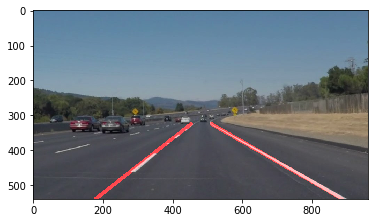

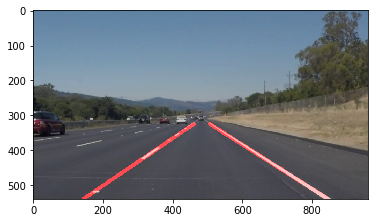

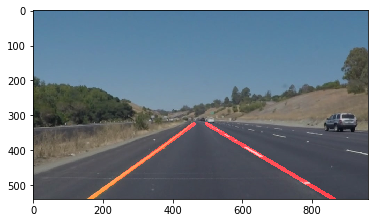

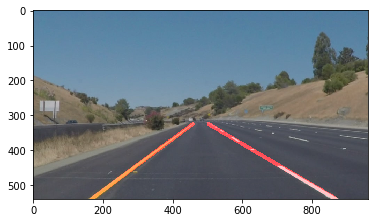

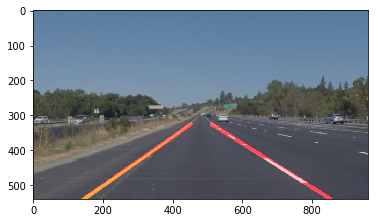

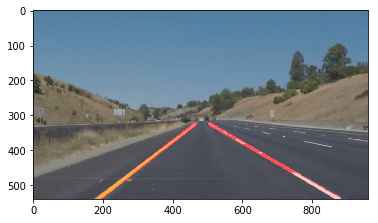

In [27]:
for img in images:                                                              # Iterate through all images in dir  
   image        = mpimg.imread("test_images/" + img)                            # Read images 
   proc_img     = image_process(image)                                          # Process image 
   plt.figure()
   plt.imshow(proc_img)

In [28]:
video_process('solidWhiteRight.mp4')                                         #Pocess video 
video_process('solidYellowLeft.mp4')                                         #Pocess video 
video_process('challenge.mp4')                                               #Pocess video 

[MoviePy] >>>> Building video processed_solidWhiteRight.mp4
[MoviePy] Writing video processed_solidWhiteRight.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 221/222 [00:03<00:00, 72.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_solidWhiteRight.mp4 

Wall time: 3.43 s
[MoviePy] >>>> Building video processed_solidYellowLeft.mp4
[MoviePy] Writing video processed_solidYellowLeft.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 681/682 [00:09<00:00, 72.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_solidYellowLeft.mp4 

Wall time: 9.81 s
[MoviePy] >>>> Building video processed_challenge.mp4
[MoviePy] Writing video processed_challenge.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:07<00:00, 31.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_challenge.mp4 

Wall time: 8.54 s
